In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
import datetime
import pandas
import numpy
import matplotlib.pyplot as plt

## Start Spark Session 
spark = SparkSession \
    .builder \
    .appName("Wrangling Data NY Taxi") \
    .getOrCreate()


In [6]:
# Import packages
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

24/12/04 21:48:20 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [7]:
# Read in data from S3 Bucket
from pyspark import SparkFiles
url = "train.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("train.csv"), sep=",", header=True)
df.show()

+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|                 N|          455|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.980415344238281|40.738563537597656|-73.999481201171875|40.731151580810547|                 N|          663|
|id3858529|        2|2016-01-19 11:35:24|2016-01-19 12:

In [14]:
df.show()

+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|                 N|          455|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.980415344238281|40.738563537597656|-73.999481201171875|40.731151580810547|                 N|          663|
|id3858529|        2|2016-01-19 11:35:24|2016-01-19 12:

In [15]:
import pandas as pd

p_df = pd.read_csv("train.csv")
p_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
import seaborn as sns

In [22]:
# Load the dataset (CSV file should be downloaded first)
# Update this path to where the file is located
file_path = "train.csv"
data = pd.read_csv(file_path)
# Basic data inspection
print(data.info())
print(data.head())
# Drop rows with missing target variable (trip duration)
data.dropna(subset=['trip_duration'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None
          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394     

In [23]:
# Feature engineering
# Convert pickup datetime to datetime object
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['hour_of_day'] = data['pickup_datetime'].dt.hour
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek

In [24]:
data['day_of_week'].unique()

array([0, 6, 1, 2, 5, 4, 3], dtype=int32)

In [25]:
# Add distance feature (Haversine formula for distance between pickup and dropoff)
def haversine(lon1, lat1, lon2, lat2):
    # Convert degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    # Earth radius in km (mean radius)
    return 6371 * c
data['distance'] = haversine(data['pickup_longitude'], data['pickup_latitude'],
                             data['dropoff_longitude'], data['dropoff_latitude'])

In [26]:
# Selecting relevant features for the model
features = ['hour_of_day', 'day_of_week', 'passenger_count', 'distance']
X = data[features]
y = data['trip_duration']  # Target variable: trip duration
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [20]:
# Predict on test data
y_pred = model.predict(X_test)

In [21]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 498.7778151183648


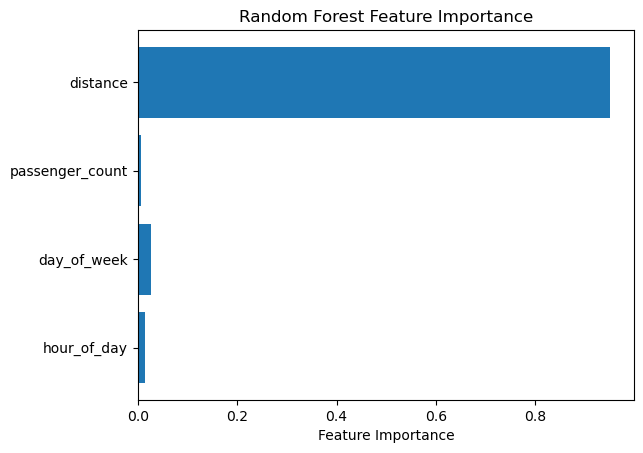

In [22]:
# Feature importance visualization
feature_importances = model.feature_importances_
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

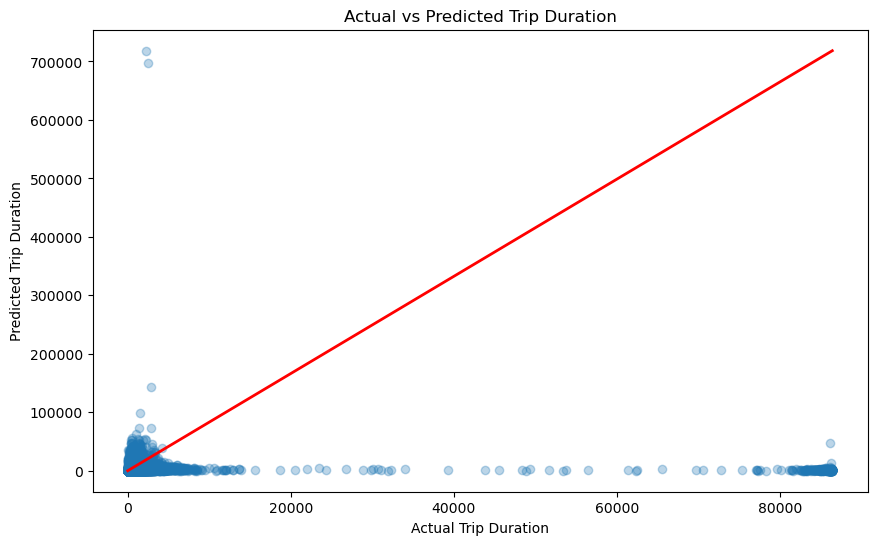

In [23]:
# Prediction vs Actuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0, max(y_test)], [0, max(y_pred)], color='red', linewidth=2)
plt.xlabel('Actual Trip Duration')
plt.ylabel('Predicted Trip Duration')
plt.title('Actual vs Predicted Trip Duration')
plt.show()

## Adding some extra analyzis from Collab

In [41]:
#stopping previous spark session to start new one
spark.stop()



In [42]:
# Create a new session
spark2 = SparkSession.builder.appName("SparkSQL2").getOrCreate()
df2 = spark2.read.csv("train.csv", header=True)

In [43]:
df2.show()

+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|                 N|          455|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.980415344238281|40.738563537597656|-73.999481201171875|40.731151580810547|                 N|          663|
|id3858529|        2|2016-01-19 11:35:24|2016-01-19 12:

In [45]:
# Display the schema
df2.printSchema()

# Summary statistics
df2.describe().show()

# Check for missing values
df2.select([df2[col].isNull().alias(col) for col in df2.columns]).show()

root
 |-- id: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: string (nullable = true)



+-------+---------+-------------------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+------------------+------------------+
|summary|       id|          vendor_id|    pickup_datetime|   dropoff_datetime|   passenger_count|   pickup_longitude|     pickup_latitude|  dropoff_longitude|   dropoff_latitude|store_and_fwd_flag|     trip_duration|
+-------+---------+-------------------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+------------------+------------------+
|  count|  1458644|            1458644|            1458644|            1458644|           1458644|            1458644|             1458644|            1458644|            1458644|           1458644|           1458644|
|   mean|     NULL| 1.5349502688798637|               NULL|               NULL|1.6645295219395548| -73.97348630489282|  40.75092

In [46]:
# Example of defining df_cleaned
df2_cleaned = df2.dropna()  # Cleaning step example

In [47]:
%whos

Variable                Type             Data/Info
--------------------------------------------------
RandomForestRegressor   ABCMeta          <class 'sklearn.ensemble.<...>t.RandomForestRegressor'>
SparkFiles              type             <class 'pyspark.files.SparkFiles'>
SparkSession            type             <class 'pyspark.sql.session.SparkSession'>
StringIndexer           ABCMeta          <class 'pyspark.ml.feature.StringIndexer'>
X                       DataFrame                 hour_of_day  day<...>1458644 rows x 4 columns]
X_test                  DataFrame                 hour_of_day  day<...>[291729 rows x 4 columns]
X_train                 DataFrame                 hour_of_day  day<...>1166915 rows x 4 columns]
data                    DataFrame                        id  vendo<...>458644 rows x 14 columns]
datetime                module           <module 'datetime' from '<...>/python3.12/datetime.py'>
df                      DataFrame        DataFrame[id: string, ven<...>g

In [49]:
# Example: Assuming the raw DataFrame is `df`
df2_cleaned = df2.dropna()  # Dropping rows with missing values
df2_cleaned = df2_cleaned.filter("trip_duration > 0")  # Example filter

In [50]:
print(df2.columns)
print(df2_cleaned.columns)

['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration']
['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration']


In [51]:
indexer = StringIndexer(inputCol="store_and_fwd_flag", outputCol="store_and_fwd_index")

In [ ]:
indexer = StringIndexer(inputCol="store_and_fwd_flag", outputCol="store_and_fwd_index")
df2_encoded = indexer.fit(df2_cleaned).transform(df2_cleaned)
df2_encoded.show()

+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+-------------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|store_and_fwd_index|
+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+-------------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|                 N|          455|                0.0|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.980415344238281|40.738563537597656|-73.999481201171875|40.731151580810547|         

In [57]:
df2_cleaned.select("store_and_fwd_flag").distinct().show()
print(df2_cleaned.columns)

+------------------+
|store_and_fwd_flag|
+------------------+
|                 Y|
|                 N|
+------------------+

['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration']


In [56]:
indexer = StringIndexer(inputCol="store_and_fwd_flag", outputCol="store_and_fwd_index")
df2_encoded = indexer.fit(df2_cleaned).transform(df2_cleaned)
df2_encoded.show()

+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+-------------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|store_and_fwd_index|
+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+-------------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|                 N|          455|                0.0|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.980415344238281|40.738563537597656|-73.999481201171875|40.731151580810547|         

In [58]:
from pyspark.sql.functions import concat_ws

df2 = df2.withColumn(
    "pickup_location", concat_ws(",", df2.pickup_latitude, df2.pickup_longitude)
).withColumn(
    "dropoff_location", concat_ws(",", df2.dropoff_latitude, df2.dropoff_longitude)
)

In [59]:
indexer = StringIndexer(inputCol="store_and_fwd_flag", outputCol="store_and_fwd_index")
df2_encoded = indexer.fit(df2_cleaned).transform(df2_cleaned)

# Verify the new column
print(df2_encoded.columns)

['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'store_and_fwd_index']


In [62]:
feature_columns = [
    "passenger_count",
    "pickup_latitude",
    "pickup_longitude",
    "dropoff_latitude",
    "dropoff_longitude",
    "store_and_fwd_index",  # Encoded column
]
print(df2_encoded.columns)

['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'store_and_fwd_index']


In [67]:
from pyspark.sql.functions import col

# Cast columns to double
df2_encoded = df2_encoded.withColumn("passenger_count", col("passenger_count").cast("double"))
df2_encoded = df2_encoded.withColumn("pickup_latitude", col("pickup_latitude").cast("double"))
df2_encoded = df2_encoded.withColumn("pickup_longitude", col("pickup_longitude").cast("double"))
df2_encoded = df2_encoded.withColumn("dropoff_latitude", col("dropoff_latitude").cast("double"))
df2_encoded = df2_encoded.withColumn("dropoff_longitude", col("dropoff_longitude").cast("double"))

df2_encoded.printSchema()

root
 |-- id: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: string (nullable = true)
 |-- store_and_fwd_index: double (nullable = false)



In [68]:
from pyspark.ml.feature import VectorAssembler

# Define the feature columns you want to assemble
feature_columns = ["passenger_count", "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]

# Create the VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the data to include the features column
df_prepared = assembler.transform(df2_encoded)

# Display the features and trip_duration
df_prepared.select("features", "trip_duration").show(truncate=False)

+--------------------------------------------------------------------------------+-------------+
|features                                                                        |trip_duration|
+--------------------------------------------------------------------------------+-------------+
|[1.0,40.76793670654297,-73.9821548461914,40.765602111816406,-73.96463012695312] |455          |
|[1.0,40.738563537597656,-73.98041534423828,40.73115158081055,-73.99948120117188]|663          |
|[1.0,40.763938903808594,-73.9790267944336,40.710086822509766,-74.00533294677734]|2124         |
|[1.0,40.719970703125,-74.01004028320312,40.70671844482422,-74.01226806640625]   |429          |
|[1.0,40.793209075927734,-73.97305297851562,40.78252029418945,-73.9729232788086] |435          |
|[6.0,40.74219512939453,-73.98285675048828,40.749183654785156,-73.99208068847656]|443          |
|[4.0,40.75783920288086,-73.9690170288086,40.76589584350586,-73.95740509033203]  |341          |
|[1.0,40.79777908325195,-73.96

In [69]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [81]:
# Define KMeans model with 3 clusters
kmeans = KMeans(featuresCol="features", k=3)

# Fit the model
kmeans_model = kmeans.fit(df_prepared)

# Make predictions (assign cluster labels to each data point)
predictions = kmeans_model.transform(df_prepared)

# Show the first few predictions with cluster labels
predictions.select("features", "prediction").show(5, truncate=False)

# Convert to Pandas DataFrame for plotting
pca_pd = predictions.toPandas()

+--------------------------------------------------------------------------------+----------+
|features                                                                        |prediction|
+--------------------------------------------------------------------------------+----------+
|[1.0,40.76793670654297,-73.9821548461914,40.765602111816406,-73.96463012695312] |1         |
|[1.0,40.738563537597656,-73.98041534423828,40.73115158081055,-73.99948120117188]|1         |
|[1.0,40.763938903808594,-73.9790267944336,40.710086822509766,-74.00533294677734]|1         |
|[1.0,40.719970703125,-74.01004028320312,40.70671844482422,-74.01226806640625]   |1         |
|[1.0,40.793209075927734,-73.97305297851562,40.78252029418945,-73.9729232788086] |1         |
+--------------------------------------------------------------------------------+----------+
only showing top 5 rows



In [71]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

# Calculate the Silhouette score
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette with squared Euclidean distance = {silhouette}")

Silhouette with squared Euclidean distance = 0.9325466355920562


In [72]:
# Get the cluster centers
centers = kmeans_model.clusterCenters()

# Print the centers
for center in centers:
    print(center)

[  5.12879933  40.75078305 -73.97293577  40.75168659 -73.97342292]
[  0.99994195  40.75120772 -73.97355009  40.75197638 -73.97337038]
[  2.22166135  40.7499028  -73.97355776  40.75118769 -73.97358626]


In [78]:
from pyspark.ml.feature import PCA

# Apply PCA to reduce the dimensionality of the features
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(predictions)
pca_result = pca_model.transform(predictions)

# Show the reduced features
pca_result.select("pca_features", "prediction").show(5, truncate=False)

+-----------------------------------------+----------+
|pca_features                             |prediction|
+-----------------------------------------+----------+
|[-0.9843630682932789,-100.82584797098447]|1         |
|[-0.9843702799312939,-100.8520320773252] |1         |
|[-0.9843688839424523,-100.85550510755203]|1         |
|[-0.9843712701829205,-100.88392814108883]|1         |
|[-0.9843597662468649,-100.82350432193036]|1         |
+-----------------------------------------+----------+
only showing top 5 rows



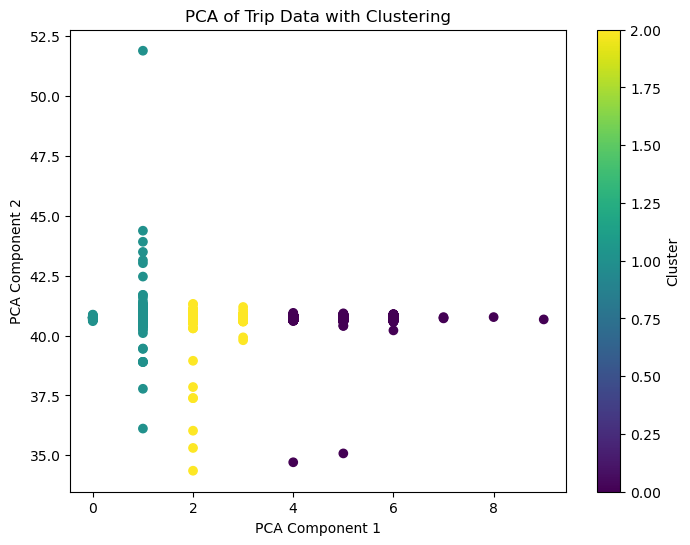

In [83]:
# Extract PCA components and cluster predictions
pca_pd['pca1'] = pca_pd['features'].apply(lambda x: x[0])  # First component
pca_pd['pca2'] = pca_pd['features'].apply(lambda x: x[1])  # Second component

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(pca_pd['pca1'], pca_pd['pca2'], c=pca_pd['prediction'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Trip Data with Clustering')
plt.colorbar(label='Cluster')
plt.show()

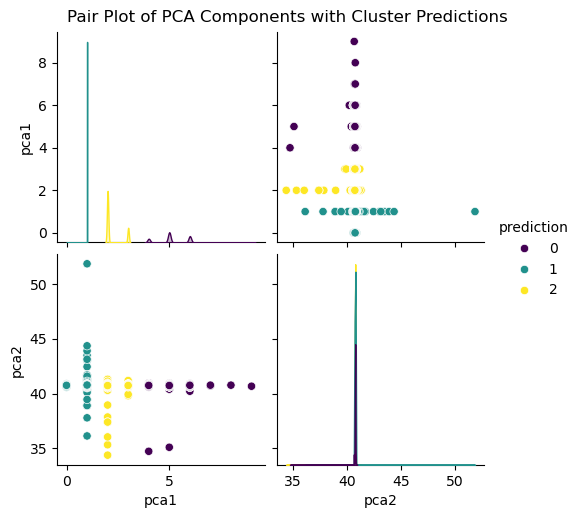

In [84]:
sns.pairplot(pca_pd, hue='prediction', vars=['pca1', 'pca2'], palette='viridis')
plt.suptitle('Pair Plot of PCA Components with Cluster Predictions', y=1.02)
plt.show()

/var/folders/st/78ppk1cn6fz138ngscfcbmhm0000gn/T/ipykernel_36818/3762447560.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='prediction', data=pca_pd, palette='viridis')


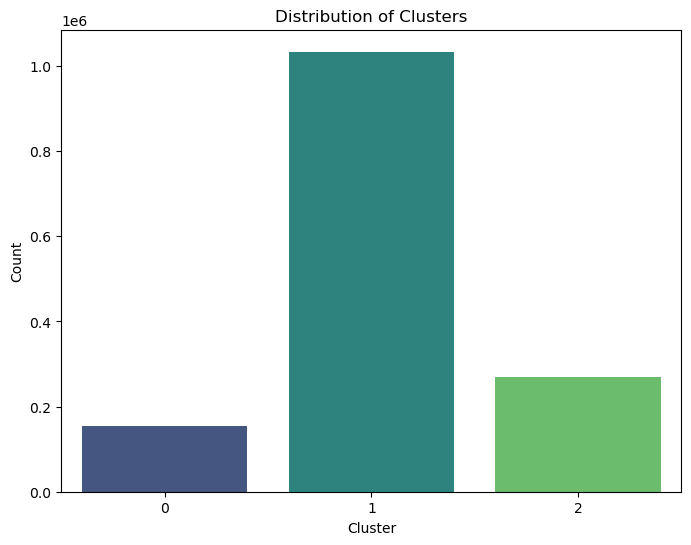

In [85]:
# Distribution of clusters
plt.figure(figsize=(8, 6))
sns.countplot(x='prediction', data=pca_pd, palette='viridis')
plt.title('Distribution of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

In [103]:
from sklearn.cluster import KMeans

Exception ignored in: <function JavaWrapper.__del__ at 0x1629cb2e0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
                                              ^^^^^^^^^^^^^^
AttributeError: 'KMeans' object has no attribute '_java_obj'


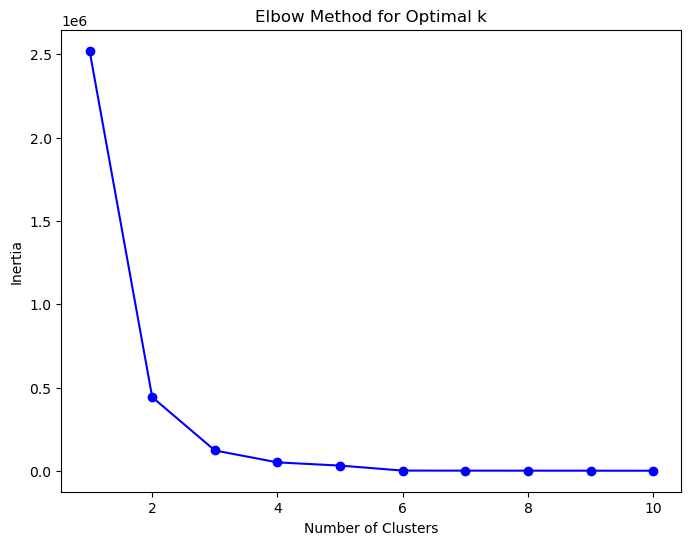

In [105]:
# Elbow plot to determine the optimal number of clusters
inertia = []
max_k = 10
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_pd[['pca1', 'pca2']])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, max_k+1), inertia, marker='o', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


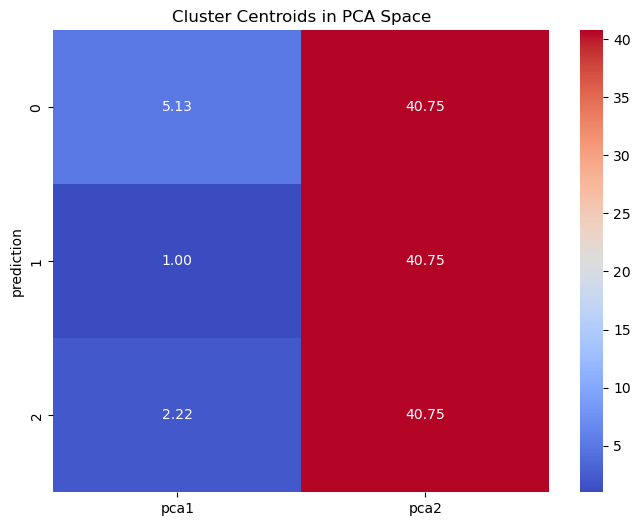

In [106]:
cluster_pca = pca_pd.groupby('prediction')[['pca1', 'pca2']].mean()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_pca, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Cluster Centroids in PCA Space')
plt.show()

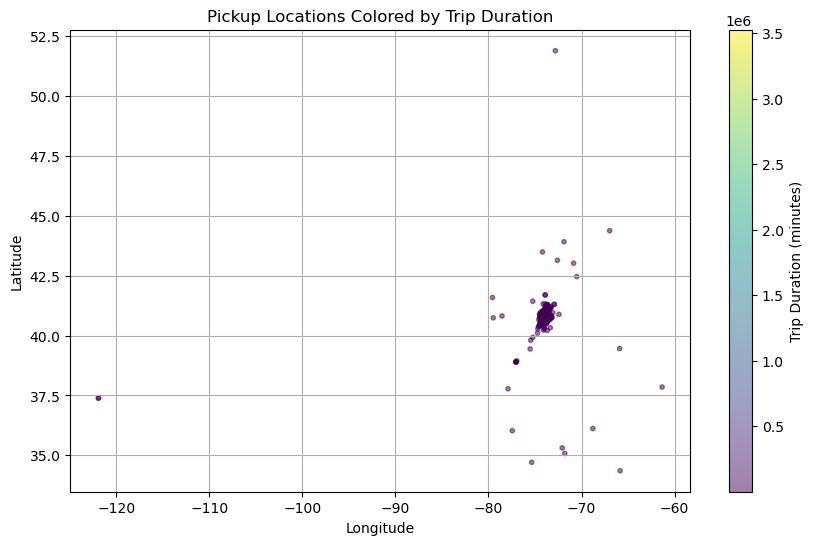

In [88]:
# Scatter Plot: Pickup vs Dropoff with Trip Duration
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    data['pickup_longitude'],
    data['pickup_latitude'],
    c=data['trip_duration'],
    cmap='viridis',
    alpha=0.5,
    s=10  # Marker size
)
plt.colorbar(scatter, label='Trip Duration (minutes)')
plt.title('Pickup Locations Colored by Trip Duration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

plt.show()

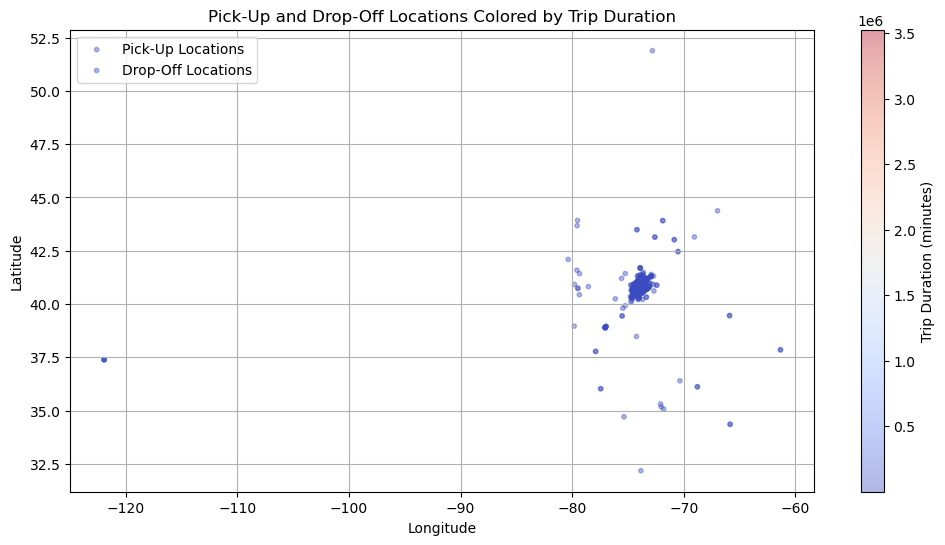

In [89]:
plt.figure(figsize=(12, 6))

# Scatter for Pick-Up Locations
plt.scatter(
    data['pickup_longitude'],
    data['pickup_latitude'],
    c=data['trip_duration'],
    cmap='coolwarm',
    alpha=0.4,
    s=10,
    label='Pick-Up Locations'
)

# Scatter for Drop-Off Locations
plt.scatter(
    data['dropoff_longitude'],
    data['dropoff_latitude'],
    c=data['trip_duration'],
    cmap='coolwarm',
    alpha=0.4,
    s=10,
    label='Drop-Off Locations'
)

plt.colorbar(label='Trip Duration (minutes)')
plt.title('Pick-Up and Drop-Off Locations Colored by Trip Duration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/st/78ppk1cn6fz138ngscfcbmhm0000gn/T/ipykernel_36818/3647217134.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = data.groupby(['pickup_lat_bin', 'pickup_long_bin'])['trip_duration'].mean().unstack()


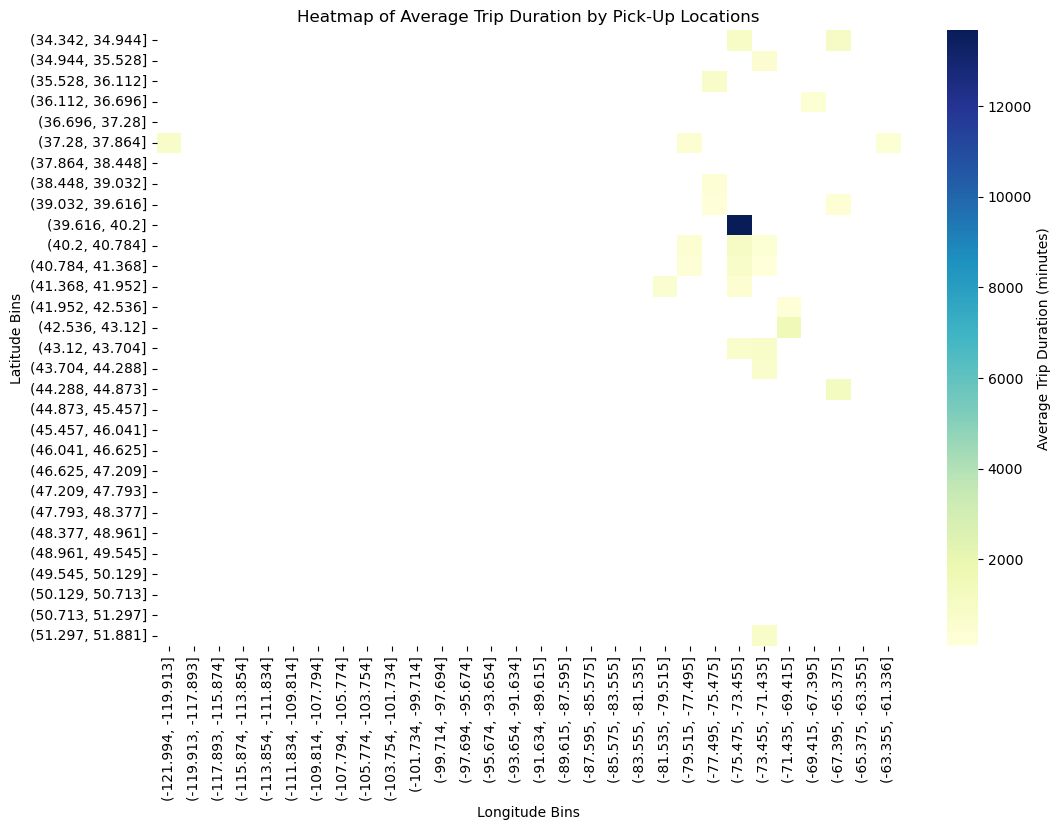

In [90]:
# Create a new column for binned spatial data
data['pickup_long_bin'] = pd.cut(data['pickup_longitude'], bins=30)
data['pickup_lat_bin'] = pd.cut(data['pickup_latitude'], bins=30)

# Aggregate by bins
heatmap_data = data.groupby(['pickup_lat_bin', 'pickup_long_bin'])['trip_duration'].mean().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    cbar_kws={'label': 'Average Trip Duration (minutes)'}
)
plt.title('Heatmap of Average Trip Duration by Pick-Up Locations')
plt.xlabel('Longitude Bins')
plt.ylabel('Latitude Bins')
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` bec

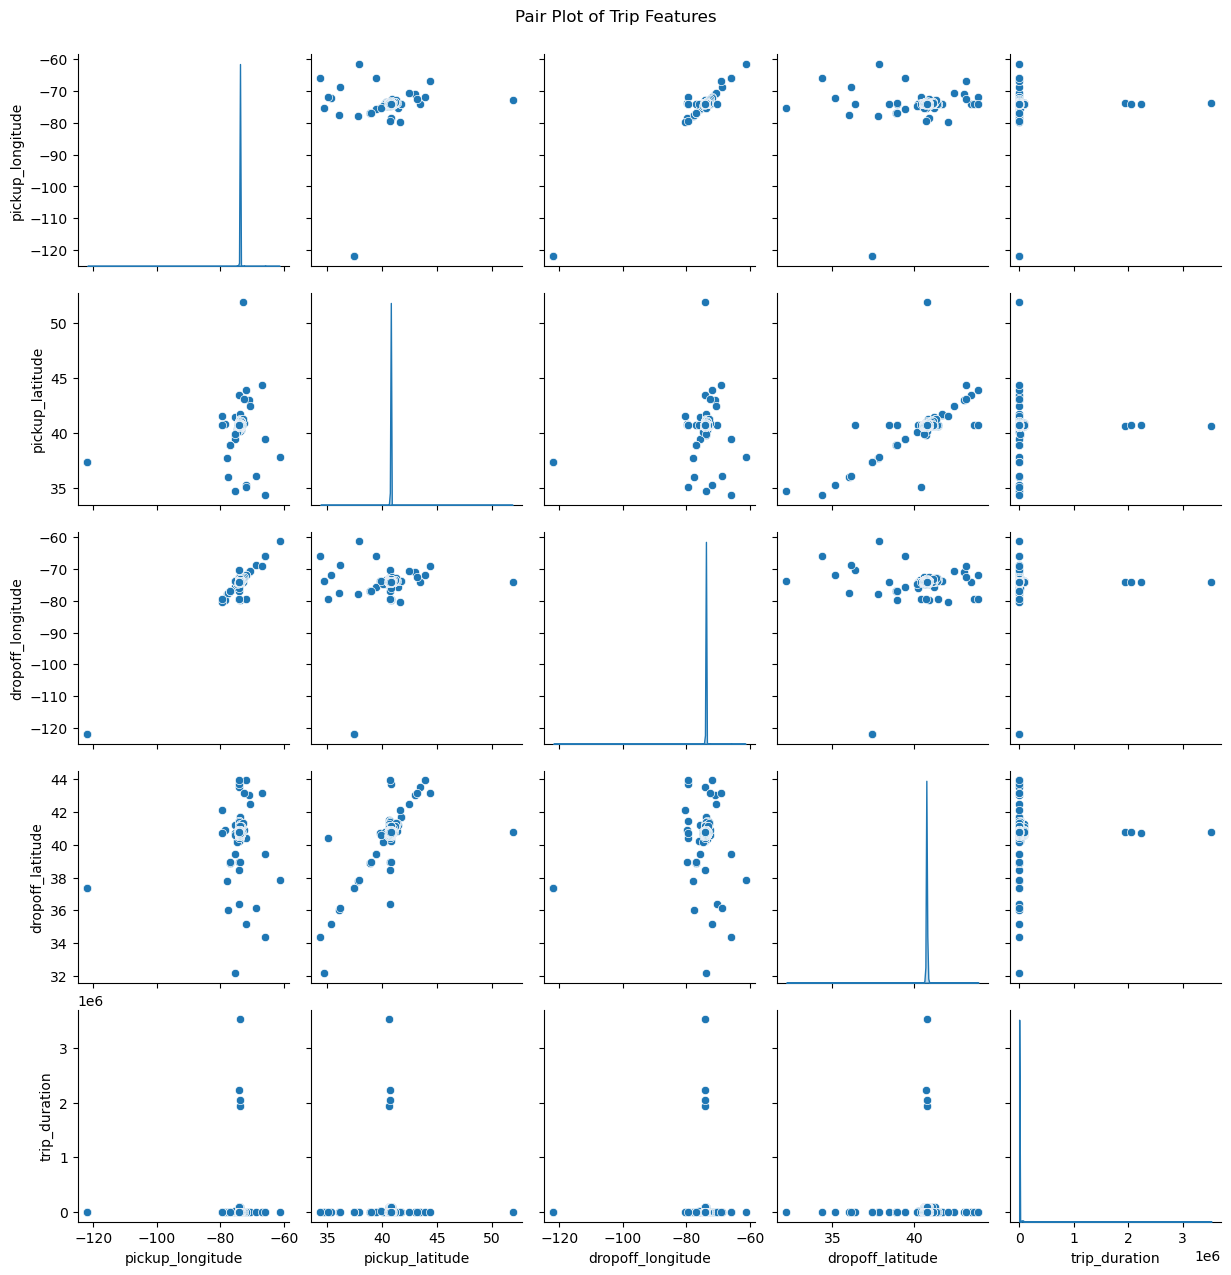

In [91]:
# Select relevant columns
pairplot_data = data[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_duration']]

# Pairplot with hue based on trip duration
sns.pairplot(pairplot_data, diag_kind='kde', palette='coolwarm')
plt.suptitle("Pair Plot of Trip Features", y=1.02)
plt.show()

/var/folders/st/78ppk1cn6fz138ngscfcbmhm0000gn/T/ipykernel_36818/862221701.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y='trip_duration', data=data, palette='viridis')


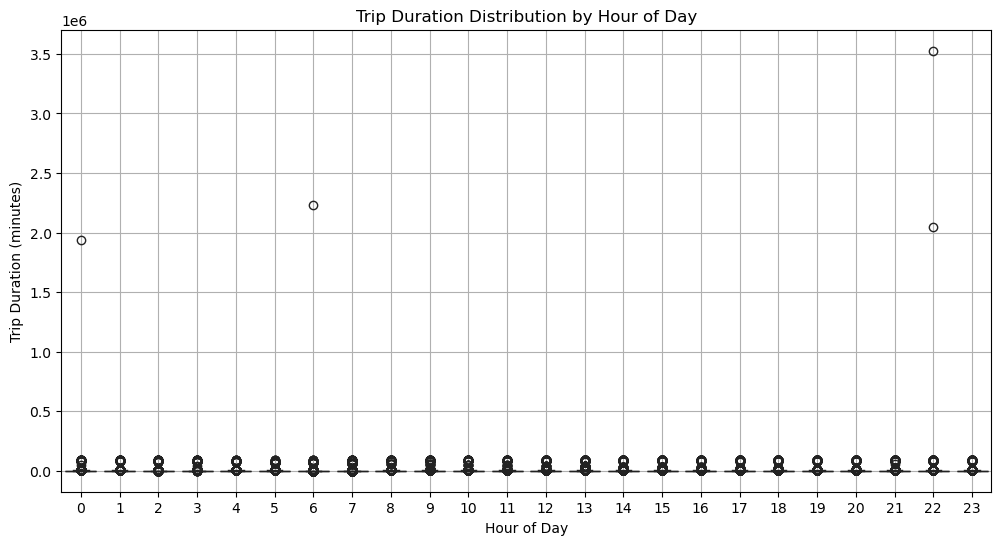

In [93]:
# Convert to datetime if necessary
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['hour'] = data['pickup_datetime'].dt.hour

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='trip_duration', data=data, palette='viridis')
plt.title('Trip Duration Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Trip Duration (minutes)')
plt.grid(True)
plt.show()